# Taylor rule and other policy rules on the fed funds rate

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

The Taylor rule is renowned for guiding policymakers in adjusting the short-term policy rate based on specific economic indicators.

**Taylor rule:**      $R_t^T = r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + 0.5(y_t - y_t^P)$

However, numerous alternative methods have also been developed and examined.

**Balanced-approach rule:**       $R_t^{BA} = r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + (y_t - y_t^P)$

**ELB-adjusted rule:** $R_t^{ELB-adj} = max\{R_t^{BA} - Z_t, ELB\}$

**Inertial rule:** $R_t^I = 0.85R_{t-1} + 0.15[r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + (y_t - y_t^P)]$

**First-difference rule:** $R_t^{FD} = R_{t-1} + 0.1(\pi_t - \pi^*) + 0.1(y_t - y_{t-4})$

- Neutral Inflation-Adjusted Federal Funds Rate ($r_t^{LR}$)
- Inflation Measurement ($\pi_t$)
- Inflation Target($\pi^*$)
- Output Gap ($y_t - y_t^P$)
- Effective Lower Bound (ELB)
- Federal Funds Rate (FFR)

This notebook examined Federal funds rate estimation using different policy rules mentioned on Fed Reserve Website: https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm. The time period will be extended from 2000-2018 to 2000-2023 in order to provide a broader analysis.

# Read Data

In Federal Reserve's method:
- $r_t^{LR}$ = $(Tbill \: Rate \: Forecast_t) - (Inflation \: Forecast_t)$ : with $Tbill \: Rate\: Forecast_t$ being the interpolated quarterly average forecast for the three-month Treasury bill rate, and $Inflation \: Forecast_t$ being the forecast for inflation of the implicit GDP price deflator from Blue Chip Economic Indicators. &nbsp; &nbsp; Source: `Blue Chip Economic Indicators`

- $\pi_t$ = $ln(PCE_{t}) - ln(PCE_{t-4})$ where represents the quarterly average of the price index for personal consumption expenditures excluding food and energy at time t. &nbsp; &nbsp; Source: `FRED PCEPILFE`

- $\pi^*$= 2\%

- $y_t - y_t^P$ = $ln(GDP_t) - ln(Potential \:GDP_t)$.  &nbsp; &nbsp;  Source: `FRED GDPC1`,`GDPPOT`

- ELB: = minimum value that FFR can reach

- FFR = current federal funds rate. &nbsp; &nbsp;   Source: `FRED FEDFUNDS`

In the replication method:

- Without access to Blue Chip Economic Indicators, $r_t^{LR}$ was extracted from LW Estimates for the Natural Rate of Interest provided by the `Federal Reserve Bank of New York`.

- Other indicators have utilized data from the same sources as the Federal Reserve's methodology.

In [ ]:
fed = pd.read_excel('./fed policy rules.xlsx')
fed.index = pd.period_range(start='2000Q1', end='2017Q3', freq='Q')
fed.index = fed.index.to_timestamp()
fed

,Year,Quarter,Observed FFR,Taylor,Balanced-approach,ELB-adjusted,Inertial,First-difference
2000-01-01,2000,1,5.68,5.02,5.54,5.54,5.34,5.68
2000-04-01,2000,2,6.27,5.58,6.55,6.55,5.81,6.16
2000-07-01,2000,3,6.52,5.33,5.88,5.88,6.21,6.65
2000-10-01,2000,4,6.47,5.17,5.54,5.54,6.37,6.79
2001-01-01,2001,1,5.59,4.54,4.31,4.31,6.15,6.68
...,...,...,...,...,...,...,...,...
2016-07-01,2016,3,0.40,2.31,2.05,0.00,0.63,0.51
2016-10-01,2016,4,0.45,2.35,2.12,0.00,0.66,0.56
2017-01-01,2017,1,0.70,2.19,1.93,0.00,0.67,0.63
2017-04-01,2017,2,0.95,1.98,1.90,0.00,0.88,0.87


### Reading data from the database

In [ ]:
data = pdr.get_data_fred(["PCEPILFE", "GDPC1", "GDPPOT","FEDFUNDS"],"1999-01-01", "2023-01-01").dropna()

In [1]:
rate = pd.DataFrame()
inflation = pd.DataFrame()
data[['ln_PCE','ln_GDP','ln_PGDP']] = np.log(data[['PCEPILFE','GDPC1','GDPPOT']])
rate['inflation'] = (data['ln_PCE'] - data['ln_PCE'].shift(4)).dropna()
rate['output_gap'] = (data['ln_GDP'] - data['ln_PGDP']).dropna()

NameError: name 'pd' is not defined

In [2]:
data

NameError: name 'data' is not defined

In [ ]:
rlr = pd.read_excel('./RLR.xlsx')
rlr.index = rlr['Date']
rlr.drop('Date', axis=1,inplace = True)
rlr['PRLR'] = rlr['RLR']/100
rate = rate.merge(rlr['PRLR'], left_index=True, right_index=True, how='inner')

**First-difference rule:** $R_t^{FD} = R_{t-1} + 0.1(\pi_t - \pi^*) + 0.1(y_t - y_{t-4})$

In [ ]:
rdf = pd.DataFrame()
rdf['rdf'] = data.loc[(data.index >= '1999-10-01') & (data.index <= '2023-01-01'), 'FEDFUNDS']
rdf['FEDFUNDS']=rdf['rdf']/100
rate['First-difference'] = rdf['FEDFUNDS'].shift(1) + 0.1 * (rate['inflation']-0.02) + 0.1 * (data['ln_GDP']/100 - data['ln_GDP'].shift(4)/100)
rate['First-difference'] = rate['First-difference'].dropna()

**Inertial rule:** $R_t^I = 0.85R_{t-1} + 0.15[r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + (y_t - y_t^P)]$

In [ ]:
rate['Inertial']=0.85*rdf['FEDFUNDS'].shift(1)+0.15*(rate['PRLR']+ rate['inflation'] +0.5*(rate['inflation']-0.02)+ rate['output_gap'])

**Taylor rule:**      $R_t^T = r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + 0.5(y_t - y_t^P)$

In [ ]:
'Observed FFR', 'Taylor', 'Balanced-approach', 'ELB-adjusted', 'Inertial', 'First-difference'

('Observed FFR',
 'Taylor',
 'Balanced-approach',
 'ELB-adjusted',
 'Inertial',
 'First-difference')

In [ ]:
ln_PCE = pd.DataFrame()
ln_PCE['ln_PCE'] = data.loc[(data.index >= '2000-01-01') & (data.index <= '2023-01-01'), 'ln_PCE']
rate['Taylor'] = rate['PRLR']+ rate['inflation']+ 0.5* (rate['inflation']-0.02) + 0.5* rate['output_gap']

**Balanced-approach rule:**       $R_t^{BA} = r_t^{LR} + \pi_t + 0.5(\pi_t - \pi^*) + (y_t - y_t^P)$

In [ ]:
rate['Balanced-approach']=rate['PRLR']+rate['inflation']+ 0.5* (rate['inflation']-0.02)+ rate['output_gap']

In [ ]:
rate['Observed FFR']=rdf.loc[(rdf.index >= '2000-01-01') & (rdf.index <= '2023-01-01'), 'FEDFUNDS']

In [ ]:
rate

,inflation,output_gap,First-difference,PRLR,Inertial,Taylor,Balanced-approach,Observed FFR
2000-01-01,0.015270,0.016023,0.051568,0.034940,0.053780,0.055856,0.063868,0.0545
2000-04-01,0.016921,0.023530,0.054243,0.036039,0.057568,0.063186,0.074952,0.0602
2000-07-01,0.017761,0.014587,0.060015,0.034831,0.061079,0.058766,0.066059,0.0654
2000-10-01,0.018021,0.011199,0.065231,0.034990,0.065073,0.057621,0.063221,0.0651
2001-01-01,0.019854,-0.000835,0.065107,0.033931,0.063267,0.053294,0.052877,0.0598
...,...,...,...,...,...,...,...,...
2022-01-01,0.052303,0.002990,0.004065,0.016783,0.013914,0.086732,0.088227,0.0008
2022-04-01,0.051215,-0.003396,0.003940,0.013514,0.012221,0.078638,0.076940,0.0033
2022-07-01,0.048424,-0.001968,0.006159,0.014890,0.014138,0.076541,0.075557,0.0168
2022-10-01,0.051889,-0.000768,0.019995,0.014444,0.026506,0.081893,0.081509,0.0308


# The Federal Reserve's graph (2000-2018)

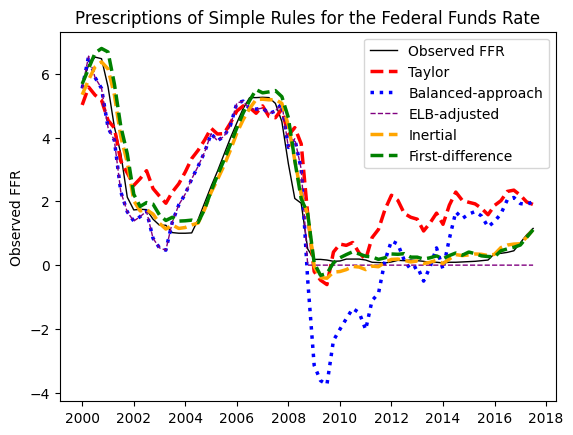

In [ ]:
palette = ['black', 'red', 'blue', 'purple', 'orange', 'green']
linestyle = ["-", "--", ":", "--", "--", "--"]
label = ['Observed FFR', 'Taylor', 'Balanced-approach', 'ELB-adjusted', 'Inertial', 'First-difference']
linewidth = [1,2.5,2.5,1,2.5,2.5]

# Plot each line with a loop
for i, label in enumerate(label):
    sns.lineplot(x=fed.index, y=fed[label], linewidth=linewidth[i], color=palette[i], linestyle=linestyle[i], label=label,errorbar=None)

plt.title('Prescriptions of Simple Rules for the Federal Funds Rate')
plt.show()


# The Replication graph (2000-2023)

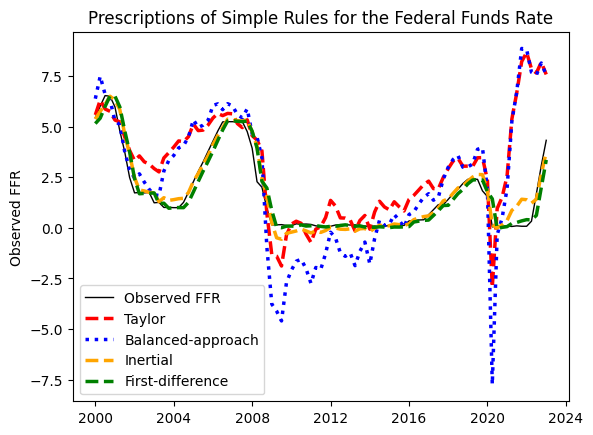

In [ ]:
palette = ['black', 'red', 'blue', 'orange', 'green']
linestyle = ["-", "--", ":", "--", "--"]
label = ['Observed FFR', 'Taylor', 'Balanced-approach', 'Inertial', 'First-difference']

linewidth = [1,2.5,2.5,2.5,2.5]

# Plot each line with a loop
for i, label in enumerate(label):
    sns.lineplot(x=rate.index, y=rate[label]*100, linewidth=linewidth[i], color=palette[i], linestyle=linestyle[i], label=label,errorbar=None)

plt.title('Prescriptions of Simple Rules for the Federal Funds Rate')
plt.show()

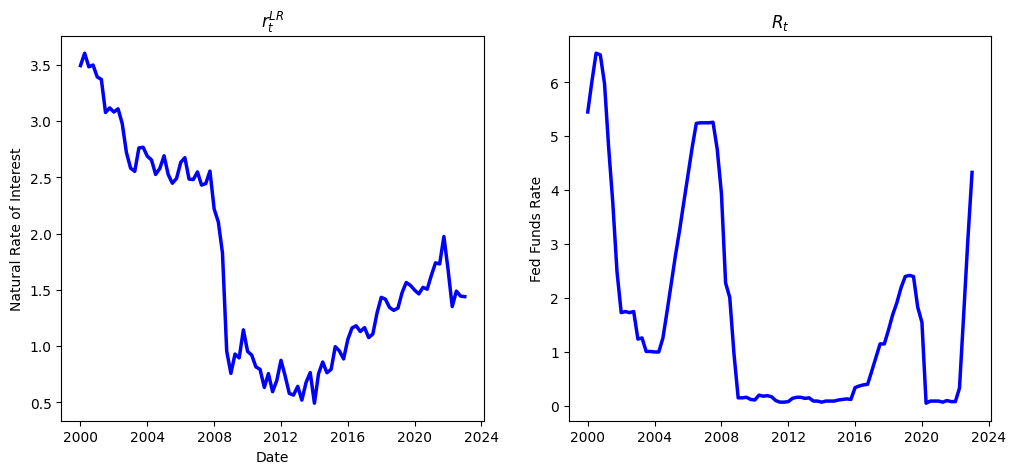

In [ ]:
filtered_rlr = rlr['2000-01-01':'2023-01-01']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=filtered_rlr.index, y=filtered_rlr['RLR'],color='blue', linewidth=2.5)
plt.ylabel('Natural Rate of Interest')
plt.title(r'$r_t^{LR}$')

plt.subplot(1, 2, 2)
sns.lineplot(x=rate.index, y=rate['Observed FFR']*100,color='blue', linewidth=2.5)
plt.ylabel('Fed Funds Rate')
plt.title(r'$R_t$')

plt.show()

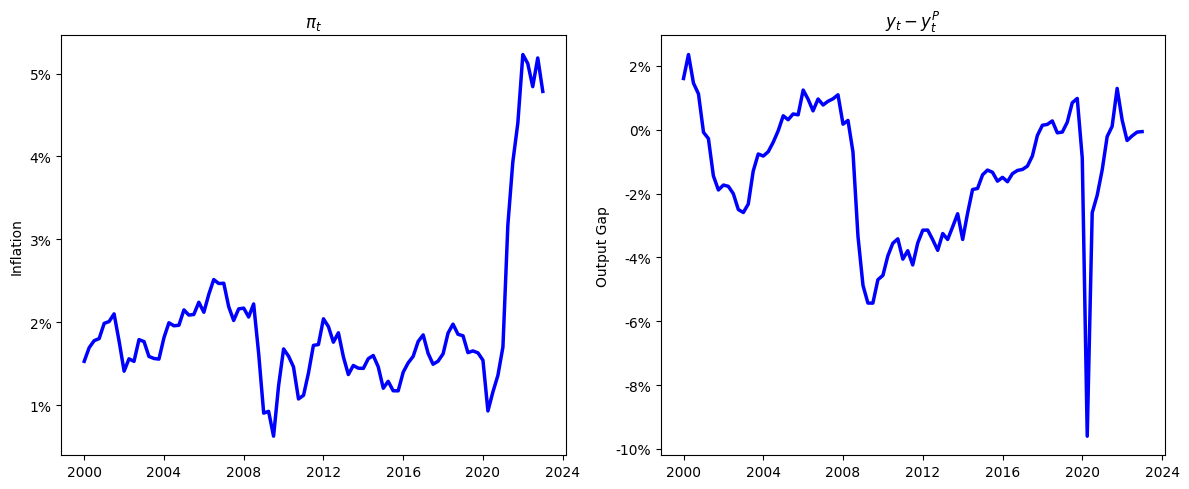

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=rate.index, y=rate['inflation'],color='blue', linewidth=2.5)
plt.ylabel('Inflation')  # Correct attribute to set y-axis label
plt.title(r'$\pi_t$')  # Using raw string for LaTeX-style title
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
sns.lineplot(x=rate.index, y=rate['output_gap'],color='blue', linewidth=2.5)
plt.ylabel('Output Gap')  # Correct attribute to set y-axis label
plt.title(r'$y_t - y_t^P$')  # Using raw string for LaTeX-style title
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()